# Phases

### Phase 1
Simulate targets with different constant velocites and frequencies \
Combine them into a single time domain \
Add noise

### Phase 2
Window with 50% hop \
Apply Hanning function to smooth \
Apply FFTs and extract frequencies and magnitude for each set of peaks in each window. \
Apply parabolic interpolation within each chunk around the peak indecies and it's two direct neighbours

### Phase 3
Convert frequency into velocity \
Smooth data with moving average 
Classify moving object based on their speed \
Print report information

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Phase 1

In [43]:
# Sensor
v_S1 = 0
V_SOUND = 343

In [68]:
targets = [
    {'vel': 45, 'freq': 6000},
    {'vel': 250, 'freq': 1500},
    {'vel': 115, 'freq': 4000},
]

num_targets = len(targets)

3

In [45]:
# Combining doppler shifted target frequencies into a single time domain signal that is recived by the sensor
sample_rate = 44100
duration = 6
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

f_shifts_list = []
f_sources_list = [targets[0]['freq'], targets[1]['freq'], targets[2]['freq']]
for target in targets:
    f_shifted = target['freq'] * (V_SOUND / (V_SOUND - target['vel']))
    f_shifts_list.append(f_shifted)

f_shifts = np.array(f_shifts_list)
f_sources = np.array(f_sources_list)

signal = 0
for shift in f_shifts:
    signal += np.sin(2*np.pi * shift * t)

In [46]:
# Adding white Gaussian noise
signal += np.random.normal(0, 0.5, signal.shape)

### Phase 2

In [47]:
# Windowing signal with 50% hop then smoothing with Hanning function
chunk_size = 1024
hop_size = chunk_size // 2
windows = []

for start in range(0, len(signal) - chunk_size + 1, hop_size):
    window = signal[start: start + chunk_size]
    smoothed_window = window * np.hanning(chunk_size)
    windows.append(smoothed_window)

In [48]:
# Applying FFTs to each window
magnitude = []
for window in windows:
    result = np.fft.rfft(window)
    magnitude.append(result)

freqs = np.fft.rfftfreq(chunk_size, 1 / sample_rate) # 1 / sample_rate is the spacing between each sample.
mag_array = np.array(magnitude) # mag_array shape is (num_windows, freq_bins)

In [49]:
# Finding peak frequency and applying parabolic interpolation for each window
all_refined_freqs = []
min_bin_separation = int(4500 / (sample_rate / chunk_size)) # Freqeuncy separation estimate: 6000 - 1500 = 4500 Hz / bin separation
for mag in mag_array:
    mag = np.abs(mag)
    peaks, _ = find_peaks(mag, prominence=30)

    # print(peaks)
    # Interpolation

    refined_freqs = [] 
    for peak_index in peaks:
        # Discounting peaks missing a neighbour from interpolation
        if peak_index == 0 or peak_index == len(mag) - 1:
            refined_freqs.append(freqs[peak_index])
            continue
    
        # Adjust peak index and adjacent magnitudes to log scale for better parabola fit
        alpha = np.log(mag[peak_index - 1])
        beta = np.log(mag[peak_index])
        gamma = np.log(mag[peak_index + 1])
    
        # Quadratic interpolation formula for vertex offset from peak frequency bin
        p = 0.5 * (alpha - gamma) / (alpha - 2*beta + gamma)
        
        refined_freq = freqs[peak_index] + p * (freqs[1] - freqs[0])
        refined_freqs.append(freqs[peak_index] + p * (freqs[1] - freqs[0]))
    
    all_refined_freqs.append(refined_freqs)
    

To see what a single window might look like run the below code.

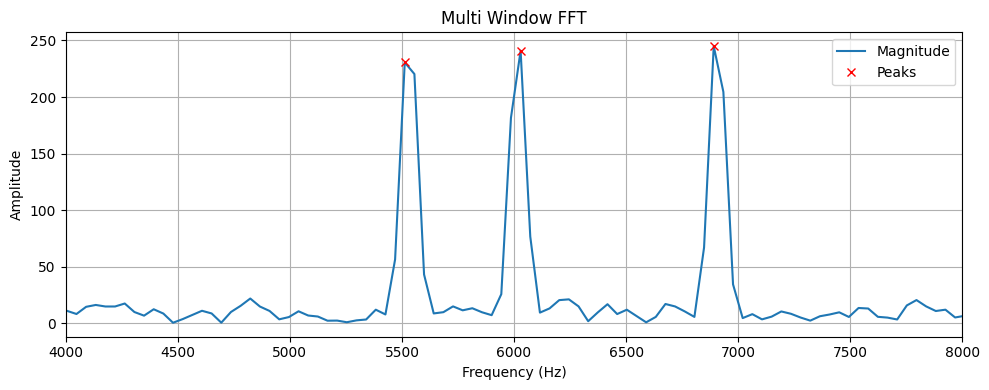

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(freqs, mag, label="Magnitude")
plt.plot(freqs[peaks], mag[peaks], 'rx', label="Peaks")
plt.title("Multi Window FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(4000, 8000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Phase 3

In [51]:
# Function returns the index of the closest shifted frequency matching freq
def classify_peak(freq, f_shifts):
    return np.argmin(np.abs(freq - f_shifts))

In [52]:
# Calculating velocities of each target
target_velocities = {0: [], 1: [], 2: [],}
for freq_list in all_refined_freqs:
    for freq in freq_list:
        target_index = classify_peak(freq, f_shifts)
        
        v = V_SOUND * (1 - (f_sources[target_index] / freq))
        target_velocities[target_index].append(v)

In [54]:
# Function to smooth data with a moving average
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [75]:
# Applying smoothing function
i = 0
smoothed_velocities = {0: [], 1: [], 2: [],}
while i < num_targets:
    smoothed_data = moving_average(target_velocities[i])
    smoothed_velocities[i].append(smoothed_data)
    i += 1

In [83]:
# Averaging velocity for each target for classification
i = 0
print("GENERATING OUTPUT REPORT")
while i < num_targets:
    avg_vel = np.average(smoothed_velocities[i])
    if avg_vel <= 50:
        classification = 'Drone'
        threat_level = "Low"
        action = 'Continue Monitoring Proximity. No Immediate Action Required.'
    elif avg_vel > 50 and avg_vel < 200:
        classification = 'Plane'
        threat_level = "Medium"
        action = 'Initiate Identification Procedures.'
    elif avg_vel >= 200:
        classification = 'Missile'
        threat_level = "High"
        action = 'SHOOT THAT PIECE OF JUNK OUT OF THE SKY!!!'
        
    print(f"Target {i+1}: \nEstimated Velocity: {avg_vel:.2f}m/s \nClassification: {classification} \nThreat Level: {threat_level} \nAction Required: {action} \n")
          
    i += 1

GENERATING OUTPUT REPORT
Target 1: 
Estimated Velocity: 46.49m/s 
Classification: Drone 
Threat Level: Low 
Action Required: Continue Monitoring Proximity. No Immediate Action Required. 

Target 2: 
Estimated Velocity: 246.63m/s 
Classification: Missile 
Threat Level: High 
Action Required: SHOOT THAT PIECE OF JUNK OUT OF THE SKY!!! 

Target 3: 
Estimated Velocity: 114.97m/s 
Classification: Plane 
Threat Level: Medium 
Action Required: Initiate Identification Procedures. 



Note that this project is limited in its scope. Although complex operations are done, it does not go so far as to find the frequncy of the tragets without hacking the target ti know its emitted frequency. Thus when calculating velocities we assume the frequencies emmited from the targets are known.